This notebook imports and aligns pacbio amplicons. 

In [1]:
import os
import warnings

from IPython.display import HTML, display

import numpy

import pandas as pd

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

import plotnine as p9

In [2]:
warnings.simplefilter('ignore')

In [3]:
p9.theme_set(dms_variants.plotnine_themes.theme_graygrid())

Import snakemake variables

In [4]:
# amplicons = snakemake.input.amplicons
# features = snakemake.input.features
# plot_amplicons = snakemake.output.plot_amplicons
# ccs_report = snakemake.input.ccs_report
# ccs_fastq = snakemake.input.ccs_fastq
# runs = snakemake.params.runs
# alignment_stats = snakemake.output.alignment_stats

amplicons = "../data/flu_sequences/pacbio_amplicons/fluCA09.gb"
features = "../data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml"
plot_amplicons = "../results/pacbio/hashing_highMOI_amplicons.svg"
ccs_report = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt"
ccs_fastq = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs.fastq.gz"
runs = ["hashing_highMOI_2020-10-20_all_segments_run1_ccs"]
outdir= "../results/pacbio/CA09_align_and_parse"
os.makedirs(outdir, exist_ok=True)
outdir= "../results/pacbio/CA09_align_and_parse"
alignment_stats = outdir



Here we import targetfiles for amplicons that where made using primers that either aligned to ends of flu sequences ('termini') or primers aligning approximately to the middle of a segment ('mid').

In [19]:
targetfile = amplicons

nlines_to_show = 100
with open(targetfile) as f:
    print(''.join(next(f) for _ in range(nlines_to_show)))

LOCUS       PB2mid                2424 bp ds-DNA     linear   SYN 02-NOV-2020
DEFINITION  PB2mid
ACCESSION   PB2mid
VERSION     .
KEYWORDS    .
SOURCE      PB2mid
  ORGANISM  
FEATURES             Location/Qualifiers
     sequenced_mRNA_1 1..1169
     variant_tag_2    1052
     final_mRNA_nts   1179..1182
     polyA            1183..1212
     UMI              1213..1224
     cellbarcode      1225..1240
     Read1            1241..1260
     termini5         1261..1287
     sequenced_mRNA_2 1288..2424
     variant_tag_1    1461
ORIGIN
        1 cagctattct cagaaaggca accaggagat tgatccagtt gatagtaagc gggagagatg
       61 agcagtcaat tgctgaggca ataattgtgg ccatggtatt ctcacaggag gattgcatga
      121 tcaaggcagt taggggcgat ctgaactttg tcaatagggc aaaccagcga ctgaacccca
      181 tgcaccaact cttgaggcat ttccaaaaag atgcaaaagt gcttttccag aactggggaa
      241 ttgaatccat cgacaatgtg atgggaatga tcggaatact gcccgacatg accccaagca
      301 cggagatgtc gctgagaggg ataagagtca gcaaaatggg agtagatgaa tactccagca
     

Feature file defines features in amplicon genbank file. 

In [43]:
feature_parse_specs_file = features
with open(feature_parse_specs_file) as f:
    print(f.read())

# default for genes with two variant tags
default_2tags: &default_2tags
  query_clip5: 5
  query_clip3: 5
  sequenced_mRNA_1:
    filter:
      clip5: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  sequenced_mRNA_2:
    filter:
      clip3: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]  
  final_mRNA_nts:
    filter:
      mutation_nt_count: null
      mutation_op_count: 2
  polyA:
    filter:
      mutation_nt_count: null
      mutation_op_count: 4
  UMI:
    return: [sequence, accuracy]
  cellbarcode:
    return: [sequence, accuracy]
  variant_tag_1:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
  variant_tag_2:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence

# use defaults to define specs for actual genes
PB2mid:
  <<: *default_2tags
PB2termini:
  <<: *default_2tags


In [44]:
targets = alignparse.targets.Targets(
                seqsfile=targetfile,
                feature_parse_specs=feature_parse_specs_file,
                ignore_feature_parse_specs_keys=['default_2tags'],
                allow_extra_features=True,
                allow_clipped_muts_seqs=True)

Now let's plot all segment amplicons.

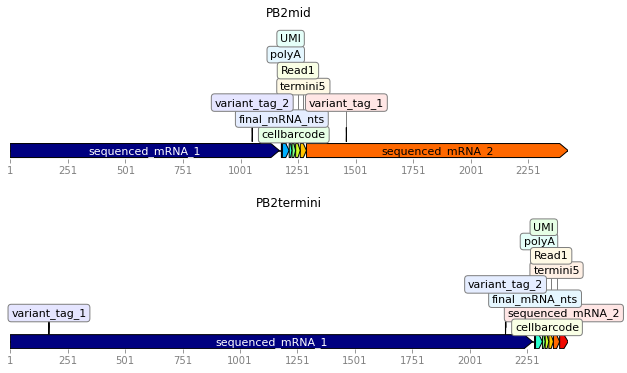

In [45]:
plot = targets.plot(ax_width=10)

In [46]:
print(f"Saving figure to {plot_amplicons}")
plot.savefig(plot_amplicons, format="svg")

Saving figure to ../results/pacbio/hashing_highMOI_amplicons.svg


Create packbio run dataframe

In [47]:
pacbio_runs = pd.DataFrame({'name': runs, 'fastq': ccs_fastq, 'report': ccs_report})
display(HTML(pacbio_runs.to_html(index=False)))

name,fastq,report
hashing_highMOI_2020-10-20_all_segments_run1_ccs,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs.fastq.gz,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt


## Align reads

The following section aligns all ccs to amplicons.

Create an alignparse.minimap2.Mapper to run minimap2 with minimap [options](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.OPTIONS_VIRUS_W_DEL) that allow for large deletions in viral sequences. 

In [48]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_VIRUS_W_DEL)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-xsplice:hq -un -C0 --splice-flank=no -M=1 --for-only --end-seed-pen=2 --end-bonus=2 --secondary=no --cs


In [49]:
os.makedirs(alignment_stats, exist_ok=True)

align_and_parse_outdir = os.path.join(alignment_stats, "{runs}")

In [50]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=align_and_parse_outdir,
        name_col='name',
        queryfile_col='fastq',
        overwrite=True,  # overwrite any existing output
        ncpus=-1,  # use all available CPUs
        )

Here are read alignment statistics:

In [51]:
readstats

,name,category,count
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered PB2mid,9310
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned PB2mid,18461
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered PB2termini,3769
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned PB2termini,6534
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,unmapped,287500


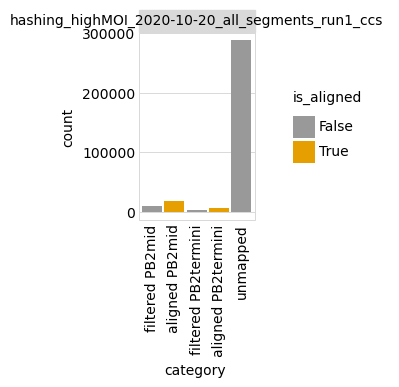

In [52]:
p = (
    p9.ggplot(readstats.assign(
               category=lambda x: pd.Categorical(x['category'],
                                                 x['category'].unique(),
                                                 ordered=True),
               is_aligned=lambda x: x['category'].str.contains('aligned'),
               ),
           p9.aes('category', 'count', fill='is_aligned')) +
    p9.geom_bar(stat='identity') +
    p9.facet_wrap('~ name', nrow=1) +
    p9.theme(axis_text_x=p9.element_text(angle=90),
          figure_size=(0.3 * len(readstats), 2.5),
          panel_grid_major_x=p9.element_blank()  # no vertical grid lines
          ) +
    p9.scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

In [53]:
for target in targets.target_names[:1]:
    print(f"First few lines of `filtered` for {target}:")
    display(filtered[target].head())

First few lines of `filtered` for PB2mid:


,name,query_name,filter_reason
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194428/ccs,query_clip3
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194544/ccs,query_clip3
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194796/ccs,sequenced_mRNA_1 clip5
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194909/ccs,sequenced_mRNA_2 clip3
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4195166/ccs,UMI mutation_nt_count


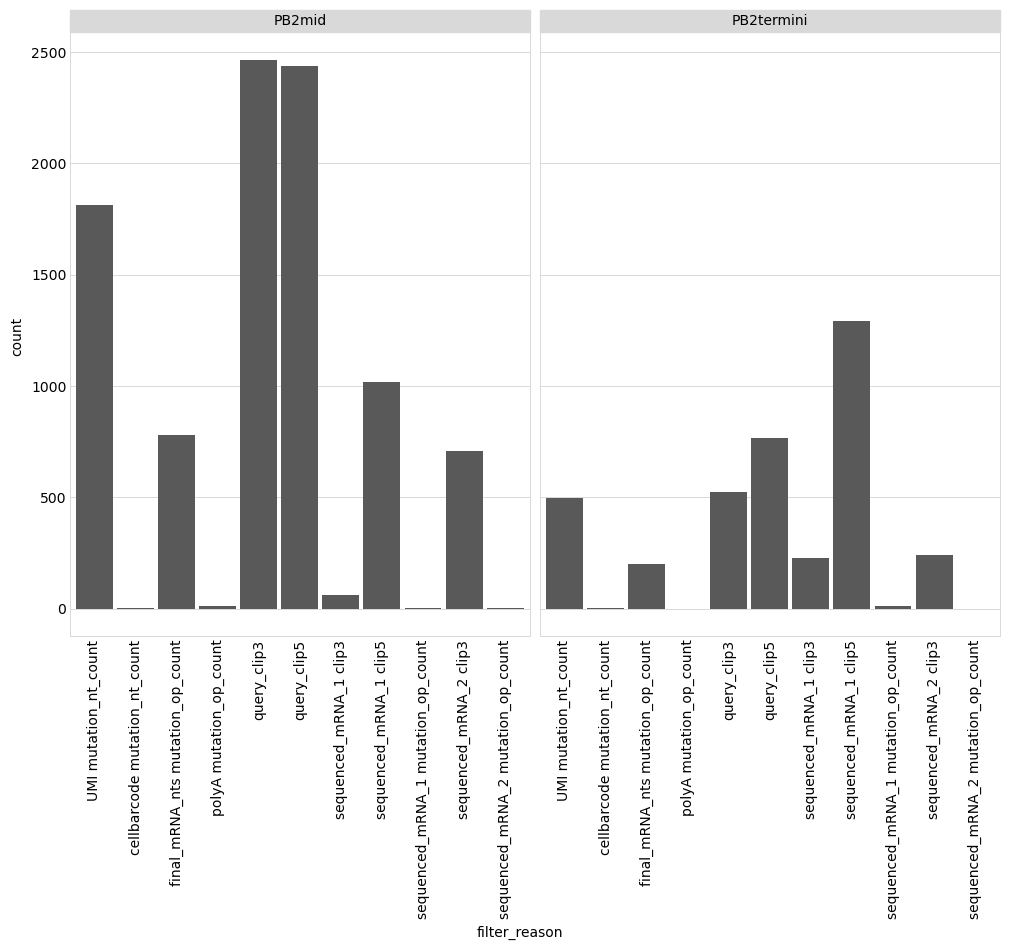

In [54]:

p = (
    p9.ggplot(pd.concat([df.assign(gene=gene) for gene, df
                      in filtered.items()])
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   x['gene'].unique(),
                                                   ordered=True)),
           p9.aes('filter_reason')) +
    p9.geom_bar() +
    p9.facet_wrap('~ gene', ncol=5) +
    p9.theme(axis_text_x=p9.element_text(angle=90),
          figure_size=(12, 8),
          panel_grid_major_x=p9.element_blank(),  # no vertical grid lines
          )
    )

_ = p.draw()